In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Cell 1: imports & seed
import os
import random
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import seaborn as sns

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [8]:
# Cell 2: dataset root (adjust if different)
DATA_ROOT = pathlib.Path('/kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage')  # update if needed
assert DATA_ROOT.exists(), f"{DATA_ROOT} does not exist - change the path to your dataset root."

# list available class folders and counts
classes = sorted([p.name for p in DATA_ROOT.iterdir() if p.is_dir()])[:-1]
print("Found classes:", classes)
for c in classes:
    cnt = len(list((DATA_ROOT / c).glob('*')))
    print(f"{c:30s}: {cnt} files")


Found classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Tomato___Bacterial_spot       : 1702 files
Tomato___Early_blight         : 800 files
Tomato___Late_blight          : 1527 files
Tomato___Leaf_Mold            : 761 files
Tomato___Septoria_leaf_spot   : 1417 files
Tomato___Spider_mites Two-spotted_spider_mite: 1341 files
Tomato___Target_Spot          : 1123 files
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 4286 files
Tomato___Tomato_mosaic_virus  : 299 files
Tomato___healthy              : 1273 files


In [36]:
# Cell 3: choose classes (edit this list for 2-4 classes to speed up)
# selected_classes = [
#     'Tomato___healthy',
#     'Tomato___Late_blight',
#     'Tomato___Early_blight',
#     'Tomato___Bacterial_spot'
# ]
# If you want to use all classes, uncomment:
selected_classes = classes

print("Using classes:", selected_classes)

# Create a temporary folder with symlinks (Kaggle friendly) or copy if needed.
WORK_DIR = pathlib.Path('/kaggle/working/plant_subset')
if WORK_DIR.exists():
    # clear and recreate to avoid duplicates
    import shutil
    shutil.rmtree(WORK_DIR)
WORK_DIR.mkdir(parents=True, exist_ok=True)

for cls in selected_classes:
    (WORK_DIR / cls).mkdir(parents=True, exist_ok=True)
    src_folder = DATA_ROOT / cls
    # link or copy a limited number of images to speed up training (optional)
    all_imgs = list(src_folder.glob('*'))
    # limit per class to 800 images for speed (adjust)
    for i, imgp in enumerate(all_imgs[:800]):  
        dst = WORK_DIR / cls / imgp.name
        if not dst.exists():
            os.symlink(imgp, dst)  # symlink is fast and saves space


Using classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [37]:
# Cell 4: dataset pipeline
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    WORK_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    WORK_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Class names:", class_names)

# Performance optimizations
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 7460 files belonging to 10 classes.
Using 5968 files for training.
Found 7460 files belonging to 10 classes.
Using 1492 files for validation.
Class names: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [40]:
# Cell 5: augmentation (simple)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
], name="data_augmentation")


In [41]:
# === Updated Cell 6: MobileNetV2 + EfficientNetB0 + NASNetMobile ===
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, NASNetMobile
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mn2
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_eff
from tensorflow.keras.applications.nasnet import preprocess_input as preprocess_nas

def build_mobilenet_v2(num_classes, img_size=IMG_SIZE):
    base = MobileNetV2(weights='imagenet', include_top=False,
                       input_shape=img_size+(3,), pooling='avg')
    base.trainable = False
    inputs = layers.Input(shape=img_size + (3,))
    x = layers.Lambda(lambda img: preprocess_mn2(img))(inputs)
    x = data_augmentation(x)
    x = base(x, training=False)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs), preprocess_mn2, "MobileNetV2"

def build_efficientnetb0(num_classes, img_size=IMG_SIZE):
    base = EfficientNetB0(weights='imagenet', include_top=False,
                          input_shape=img_size+(3,), pooling='avg')
    base.trainable = False
    inputs = layers.Input(shape=img_size + (3,))
    x = layers.Lambda(lambda img: preprocess_eff(img))(inputs)
    x = data_augmentation(x)
    x = base(x, training=False)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs), preprocess_eff, "EfficientNetB0"

def build_nasnet_mobile(num_classes, img_size=IMG_SIZE):
    base = NASNetMobile(weights='imagenet', include_top=False,
                        input_shape=img_size+(3,), pooling='avg')
    base.trainable = False
    inputs = layers.Input(shape=img_size + (3,))
    x = layers.Lambda(lambda img: preprocess_nas(img))(inputs)
    x = data_augmentation(x)
    x = base(x, training=False)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs), preprocess_nas, "NASNetMobile"

# Collect all three builders
model_factories = [
    build_mobilenet_v2,
    build_efficientnetb0,
    build_nasnet_mobile
]


In [42]:
# === Cell 7 replacement: train each model in a loop ===
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

RESULTS = {}  # store histories and metrics

EPOCHS = 5
for factory in model_factories:
    model, preprocess_fn, short_name = factory(num_classes)
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    print("\n\n======== Training:", short_name, "========")
    model.summary()

    # callbacks: checkpoint per-model
    ckpt_path = f"/kaggle/working/{short_name}_best.h5"
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, verbose=1)
    ]

    hist = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)
    # load best weights (safety)
    model.load_weights(ckpt_path)

    # evaluate
    val_loss, val_acc = model.evaluate(val_ds, verbose=0)
    print(f"{short_name} Validation accuracy: {val_acc:.4f}, loss: {val_loss:.4f}")

    # store
    RESULTS[short_name] = {
        'model': model,
        'history': hist.history,
        'val_acc': val_acc,
        'val_loss': val_loss,
        'ckpt_path': ckpt_path
    }




======== Training: MobileNetV2 ========


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_7 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3873 - loss: 1.7690
Epoch 1: val_loss improved from inf to 0.79139, saving model to /kaggle/working/MobileNetV2_best.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 28s 106ms/step - accuracy: 0.3881 - loss: 1.7666 - val_accuracy: 0.7466 - val_loss: 0.7914
Epoch 2/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7293 - loss: 0.8084
Epoch 2: val_loss improved from 0.79139 to 0.65914, saving model to /kaggle/working/MobileNetV2_best.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - accuracy: 0.7294 - loss: 0.8082 - val_accuracy: 0.7842 - val_loss: 0.6591
Epoch 3/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7884 - loss: 0.6575
Epoch 3: val_loss improved from 0.65914 to 0.57974, saving model to /kaggle/working/MobileNetV2_best.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.7884 - loss: 0.6573 - val_accuracy: 0.8083 - val_loss: 0.5797
Epoch 4/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8094 - loss: 0.5489
Epoch 4: val_loss improved from 0.57974 to 0.52624, saving model to /kaggle/working/MobileNetV2_best.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.8095 - loss: 0.5489 - val_accuracy: 0.8190 - val_loss: 0.5262
Epoch 5/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8345 - loss: 0.4918
Epoch 5: val_loss did not improve from 0.52624
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.8345 - loss: 0.4919 - val_accuracy: 0.8123 - val_loss: 0.5304
MobileNetV2 Validation accuracy: 0.8190, loss: 0.5262


======== Training: EfficientNetB0 ========


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_23 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_8 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/5


E0000 00:00:1762987147.455176      48 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_13_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4155 - loss: 1.7792
Epoch 1: val_loss improved from inf to 0.93168, saving model to /kaggle/working/EfficientNetB0_best.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - accuracy: 0.4163 - loss: 1.7772 - val_accuracy: 0.7165 - val_loss: 0.9317
Epoch 2/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7564 - loss: 0.8444
Epoch 2: val_loss improved from 0.93168 to 0.67280, saving model to /kaggle/working/EfficientNetB0_best.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.7565 - loss: 0.8441 - val_accuracy: 0.8076 - val_loss: 0.6728
Epoch 3/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8172 - loss: 0.6534
Epoch 3: val_loss improved from 0.67280 to 0.53449, saving model to /kaggle/working/EfficientNetB0_best.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.8173 - loss: 0.6532 - val_accuracy: 0.8472 - val_loss: 0.5345
Epoch 4/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8520 - loss: 0.5299
Epoch 4: val_loss improved from 0.53449 to 0.49913, saving model to /kaggle/working/EfficientNetB0_best.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.8519 - loss: 0.5299 - val_accuracy: 0.8492 - val_loss: 0.4991
Epoch 5/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.8718 - loss: 0.4632
Epoch 5: val_loss improved from 0.49913 to 0.45074, saving model to /kaggle/working/EfficientNetB0_best.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.8718 - loss: 0.4632 - val_accuracy: 0.8673 - val_loss: 0.4507
EfficientNetB0 Validation accuracy: 0.8673, loss: 0.4507


======== Training: NASNetMobile ========


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_25 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_9 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ nasnet_mobile (Functional)      │ (None, 1056)           │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1056)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │        10,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,280,286 (16.33 MB)

 Trainable params: 10,570 (41.29 KB)

 Non-trainable params: 4,269,716 (16.29 MB)

Epoch 1/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3225 - loss: 1.9573
Epoch 1: val_loss improved from inf to 1.17214, saving model to /kaggle/working/NASNetMobile_best.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 46s 143ms/step - accuracy: 0.3232 - loss: 1.9556 - val_accuracy: 0.6428 - val_loss: 1.1721
Epoch 2/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.6121 - loss: 1.1591
Epoch 2: val_loss improved from 1.17214 to 0.93895, saving model to /kaggle/working/NASNetMobile_best.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.6122 - loss: 1.1589 - val_accuracy: 0.7198 - val_loss: 0.9390
Epoch 3/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6737 - loss: 0.9656
Epoch 3: val_loss improved from 0.93895 to 0.82774, saving model to /kaggle/working/NASNetMobile_best.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.6738 - loss: 0.9655 - val_accuracy: 0.7426 - val_loss: 0.8277
Epoch 4/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7000 - loss: 0.8764
Epoch 4: val_loss improved from 0.82774 to 0.78232, saving model to /kaggle/working/NASNetMobile_best.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - accuracy: 0.7001 - loss: 0.8763 - val_accuracy: 0.7554 - val_loss: 0.7823
Epoch 5/5
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7289 - loss: 0.7954
Epoch 5: val_loss improved from 0.78232 to 0.72835, saving model to /kaggle/working/NASNetMobile_best.h5


187/187 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.7289 - loss: 0.7955 - val_accuracy: 0.7714 - val_loss: 0.7283
NASNetMobile Validation accuracy: 0.7714, loss: 0.7283




--- Eval for MobileNetV2 ---
Classification Report for MobileNetV2
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot     0.7394    0.8777    0.8026       139
                        Tomato___Early_blight     0.8375    0.4589    0.5929       146
                         Tomato___Late_blight     0.8571    0.9036    0.8798       166
                           Tomato___Leaf_Mold     0.8675    0.8623    0.8649       167
                  Tomato___Septoria_leaf_spot     0.8288    0.7516    0.7883       161
Tomato___Spider_mites Two-spotted_spider_mite     0.8897    0.7469    0.8121       162
                         Tomato___Target_Spot     0.6025    0.8471    0.7042       170
       Tomato___Tomato_Yellow_Leaf_Curl_Virus     0.9573    0.9515    0.9544       165
                 Tomato___Tomato_mosaic_virus     0.9792    0.7581    0.8545        62
                             Tomato___healthy     0.8613    

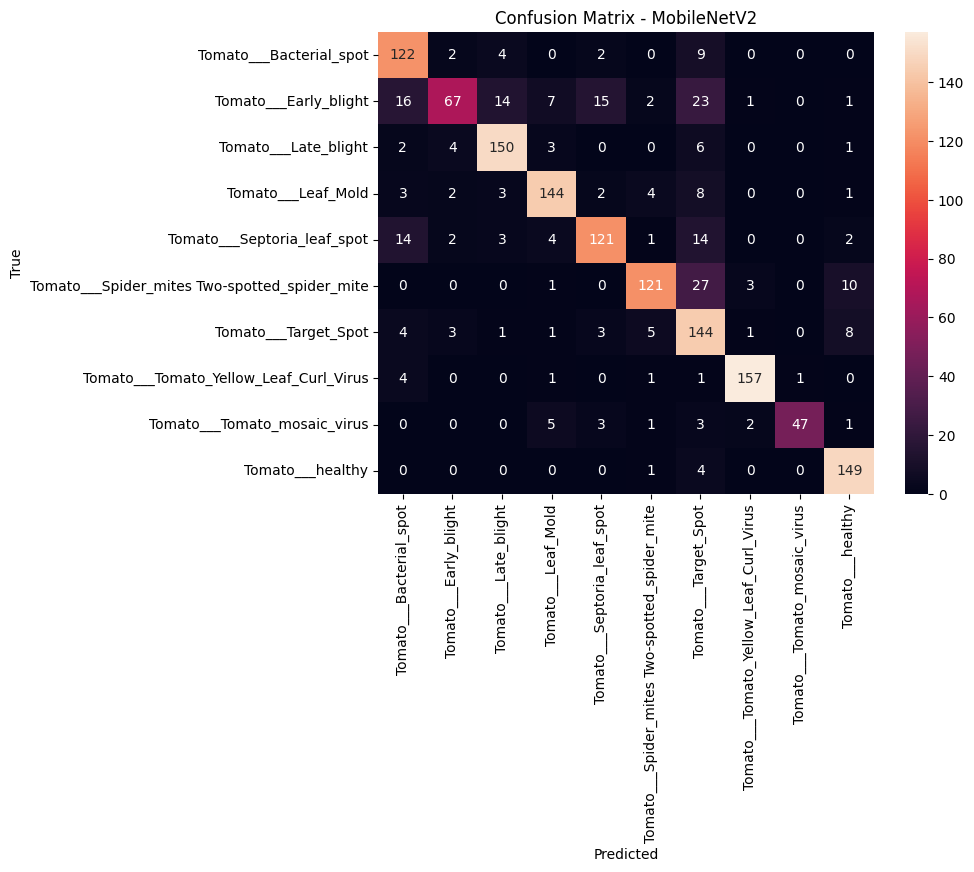



--- Eval for EfficientNetB0 ---
Classification Report for EfficientNetB0
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot     0.9286    0.8417    0.8830       139
                        Tomato___Early_blight     0.9450    0.7055    0.8078       146
                         Tomato___Late_blight     0.8982    0.9036    0.9009       166
                           Tomato___Leaf_Mold     0.8830    0.9042    0.8935       167
                  Tomato___Septoria_leaf_spot     0.8727    0.8944    0.8834       161
Tomato___Spider_mites Two-spotted_spider_mite     0.8889    0.8395    0.8635       162
                         Tomato___Target_Spot     0.7277    0.8176    0.7701       170
       Tomato___Tomato_Yellow_Leaf_Curl_Virus     0.9935    0.9273    0.9592       165
                 Tomato___Tomato_mosaic_virus     0.9792    0.7581    0.8545        62
                             Tomato___healthy     0.74

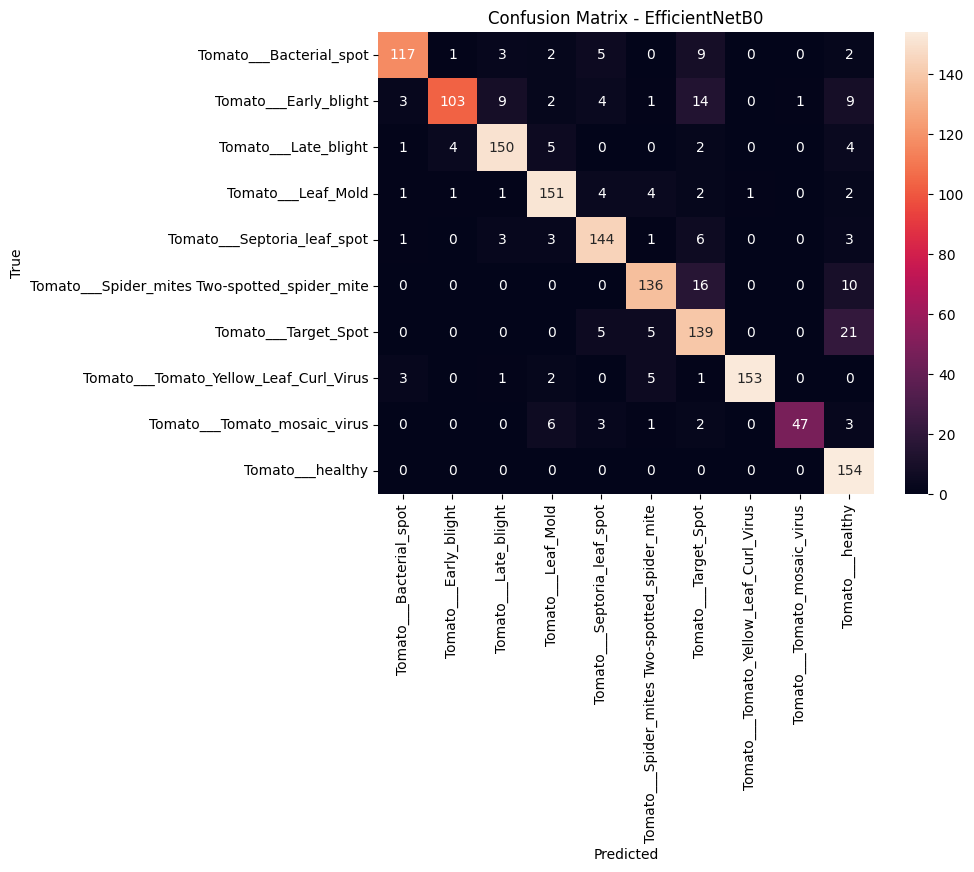



--- Eval for NASNetMobile ---
Classification Report for NASNetMobile
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot     0.7857    0.8705    0.8259       139
                        Tomato___Early_blight     0.6777    0.5616    0.6142       146
                         Tomato___Late_blight     0.8521    0.7289    0.7857       166
                           Tomato___Leaf_Mold     0.8722    0.6946    0.7733       167
                  Tomato___Septoria_leaf_spot     0.7133    0.6646    0.6881       161
Tomato___Spider_mites Two-spotted_spider_mite     0.7204    0.8272    0.7701       162
                         Tomato___Target_Spot     0.6111    0.7765    0.6839       170
       Tomato___Tomato_Yellow_Leaf_Curl_Virus     0.9684    0.9273    0.9474       165
                 Tomato___Tomato_mosaic_virus     0.9500    0.6129    0.7451        62
                             Tomato___healthy     0.7656  

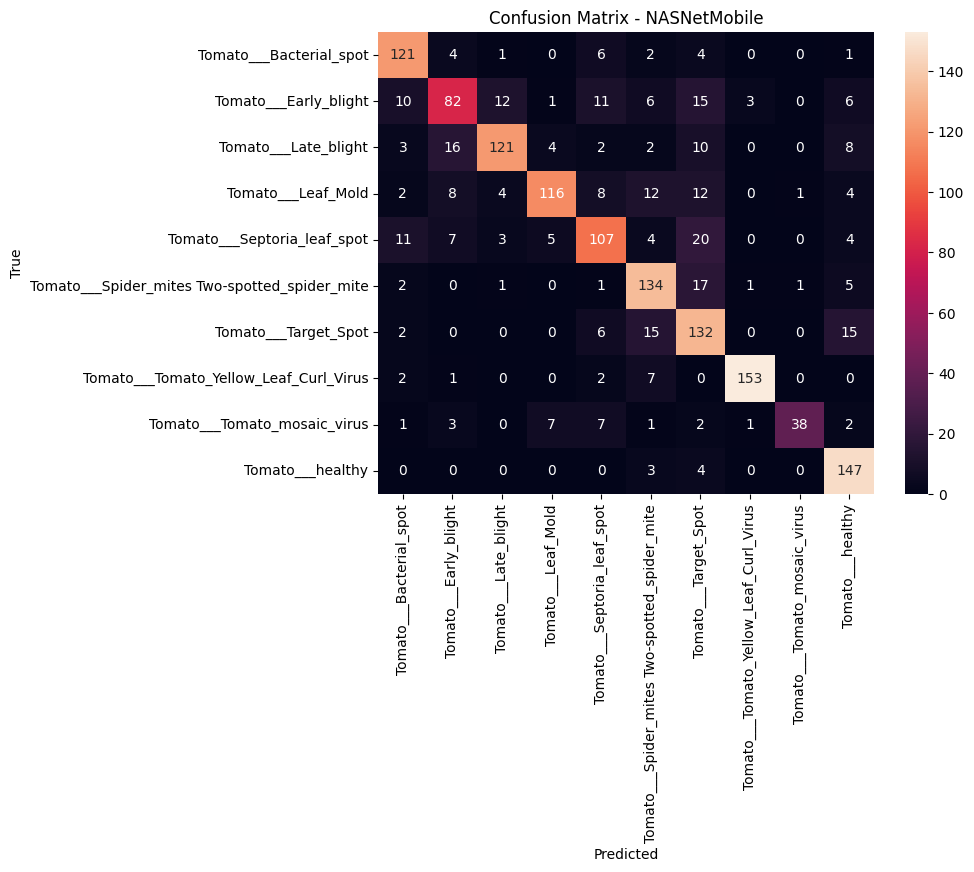


=== Summary (sorted by val_acc) ===
            model   val_acc  val_loss
1  EfficientNetB0  0.867292  0.450742
0     MobileNetV2  0.819035  0.526240
2    NASNetMobile  0.771448  0.728349


In [43]:
# === Cell 8 replacement: detailed evaluation and comparison ===
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

summary_rows = []
for name, info in RESULTS.items():
    model = info['model']
    print("\n\n--- Eval for", name, "---")
    # predictions over validation set
    y_true = []
    y_pred = []
    for imgs, labels in val_ds:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(labels.numpy().tolist())
        y_pred.extend(np.argmax(preds, axis=1).tolist())

    print("Classification Report for", name)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.show()

    summary_rows.append({'model': name, 'val_acc': info['val_acc'], 'val_loss': info['val_loss']})

summary_df = pd.DataFrame(summary_rows).sort_values('val_acc', ascending=False)
print("\n=== Summary (sorted by val_acc) ===")
print(summary_df)


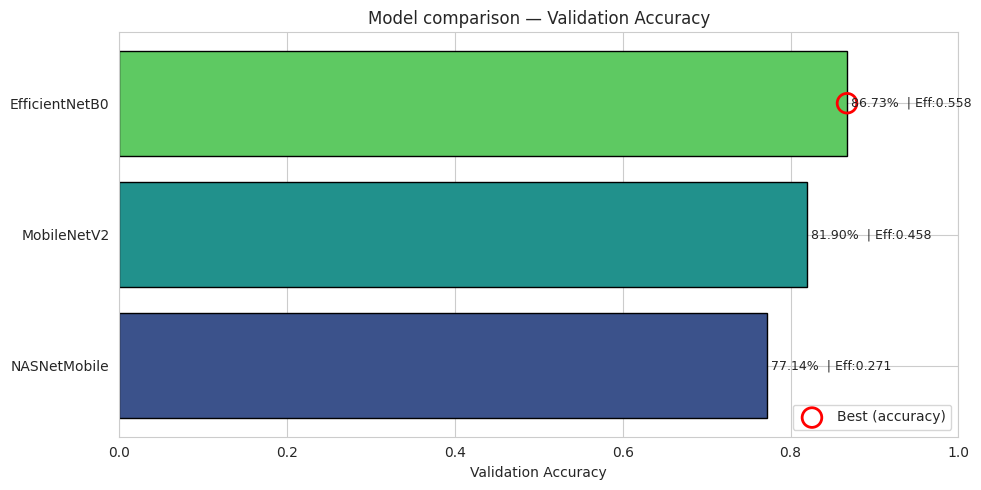

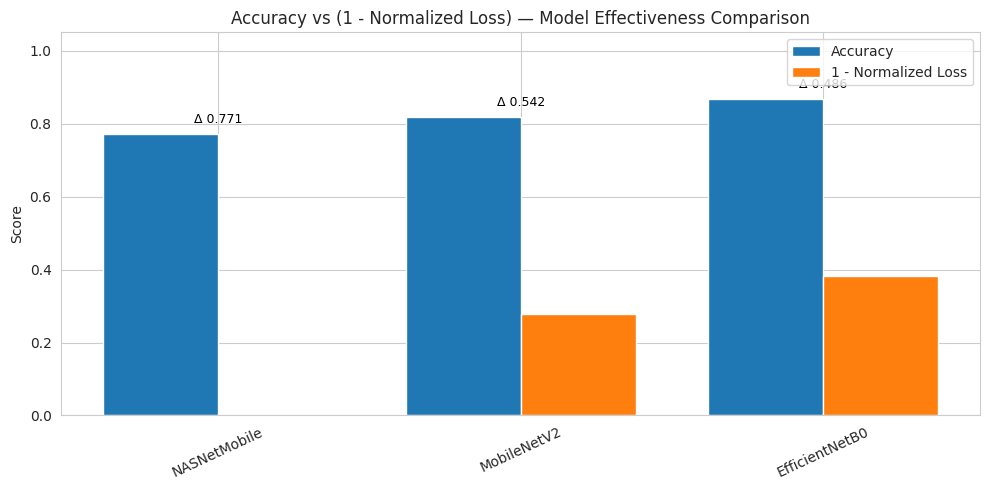

Best performing model: EfficientNetB0 with validation accuracy = 86.73%
Second best accuracy = 81.90%. Relative improvement = 5.89%

Interpretation guidance:
- Higher validation accuracy indicates better classification performance on held-out data.
- 'Effectiveness' here is a composite visualization metric (accuracy penalized modestly by loss).
- Use the confusion matrices and class-level reports (already generated) to inspect per-class weakness (high-level accuracy can mask class-specific errors).


In [45]:
# Plot comparison of models: accuracy and effectiveness
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Build summary_df if missing (RESULTS should exist from training loop)
if 'summary_df' not in globals():
    summary_rows = []
    for name, info in RESULTS.items():
        summary_rows.append({'model': name, 'val_acc': float(info['val_acc']), 'val_loss': float(info['val_loss'])})
    summary_df = pd.DataFrame(summary_rows).sort_values('val_acc', ascending=False).reset_index(drop=True)

# sort for plotting
summary_df = summary_df.sort_values('val_acc', ascending=True).reset_index(drop=True)

# compute an "effectiveness" metric for visualization:
# Here: effectiveness = val_acc - normalized_val_loss (simple interpretive metric)
# Normalize loss to [0,1] by dividing by max loss in the table (so scales comparable)
max_loss = summary_df['val_loss'].max() if summary_df['val_loss'].max() > 0 else 1.0
summary_df['norm_loss'] = summary_df['val_loss'] / max_loss
summary_df['effectiveness'] = summary_df['val_acc'] - summary_df['norm_loss'] * 0.5  # weight loss effect modestly

# Figure 1: horizontal bar - validation accuracy (neat)
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
palette = sns.color_palette("viridis", n_colors=len(summary_df))
bars = plt.barh(summary_df['model'], summary_df['val_acc'], color=palette, edgecolor='k')
plt.xlim(0, 1.0)
plt.xlabel("Validation Accuracy")
plt.title("Model comparison — Validation Accuracy")

# annotate bars with percentages and effectiveness note
for i, (acc, eff) in enumerate(zip(summary_df['val_acc'], summary_df['effectiveness'])):
    plt.text(acc + 0.005, i, f"{acc*100:.2f}%  | Eff:{eff:.3f}", va='center', fontsize=9)

# Mark the best model
best_row = summary_df.loc[summary_df['val_acc'].idxmax()]
plt.scatter(best_row['val_acc'], best_row.name, s=200, facecolors='none', edgecolors='red', linewidths=2, label='Best (accuracy)')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# Figure 2: grouped bar chart comparing accuracy and (1 - loss) for quick effectiveness intuition
summary_df['one_minus_loss'] = 1.0 - summary_df['val_loss'] / (summary_df['val_loss'].max() if summary_df['val_loss'].max()>0 else 1.0)
x = np.arange(len(summary_df))
width = 0.38

plt.figure(figsize=(10,5))
plt.bar(x - width/2, summary_df['val_acc'], width, label='Accuracy', color=sns.color_palette("tab10")[0])
plt.bar(x + width/2, summary_df['one_minus_loss'], width, label='1 - Normalized Loss', color=sns.color_palette("tab10")[1])
plt.xticks(x, summary_df['model'], rotation=25)
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("Accuracy vs (1 - Normalized Loss) — Model Effectiveness Comparison")
plt.legend()

# annotate difference and highlight top performer
for i, row in summary_df.iterrows():
    acc = row['val_acc']
    oml = row['one_minus_loss']
    diff = (acc - oml)
    plt.text(i, max(acc, oml) + 0.03, f"Δ {diff:.3f}", ha='center', fontsize=9, color='black')

# Summary text printed below plot
best = summary_df.iloc[-1] if summary_df['val_acc'].iloc[-1] >= summary_df['val_acc'].iloc[0] else summary_df.loc[summary_df['val_acc'].idxmax()]
best_idx = summary_df['val_acc'].idxmax()
best_model = summary_df.loc[best_idx, 'model']
best_acc = summary_df.loc[best_idx, 'val_acc']
# find second best
second_idx = summary_df['val_acc'].nlargest(2).index[-1] if len(summary_df)>1 else best_idx
second_acc = summary_df.loc[second_idx, 'val_acc']
pct_diff = (best_acc - second_acc) / second_acc * 100 if second_acc>0 else 0

plt.tight_layout()
plt.show()

print(f"Best performing model: {best_model} with validation accuracy = {best_acc*100:.2f}%")
if len(summary_df) > 1:
    print(f"Second best accuracy = {second_acc*100:.2f}%. Relative improvement = {pct_diff:.2f}%")
print("\nInterpretation guidance:")
print("- Higher validation accuracy indicates better classification performance on held-out data.")
print("- 'Effectiveness' here is a composite visualization metric (accuracy penalized modestly by loss).")
print("- Use the confusion matrices and class-level reports (already generated) to inspect per-class weakness (high-level accuracy can mask class-specific errors).")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


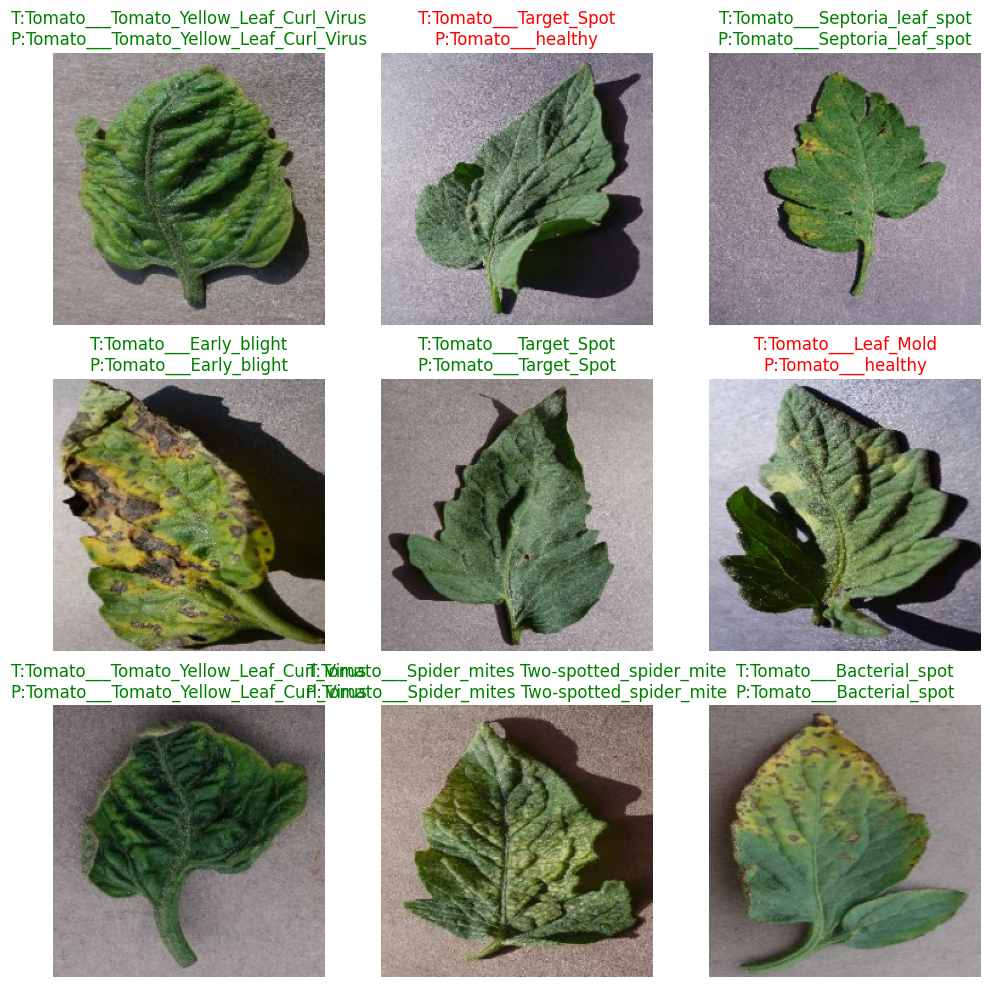

In [44]:
# Cell 9: plot sample predictions
plt.figure(figsize=(12,12))
i = 0
for images, labels in val_ds.take(3):  # take 3 batches
    preds = model.predict(images)
    for j in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[j].numpy().astype("uint8"))
        true = class_names[int(labels[j])]
        pred = class_names[int(np.argmax(preds[j]))]
        color = "green" if true == pred else "red"
        plt.title(f"T:{true}\nP:{pred}", color=color)
        plt.axis('off')
        i += 1
        if i >= 9:
            break
    if i >= 9:
        break
plt.show()


In [ ]:
# # === Cell 10 replacement: Save and convert each model to TFLite ===
# def convert_and_save_tflite(keras_model, saved_dir, tflite_path, quantize=False, representative_ds=None):
#     keras_model.save(saved_dir, include_optimizer=False)
#     converter = tf.lite.TFLiteConverter.from_saved_model(saved_dir)
#     if quantize and (representative_ds is not None):
#         converter.optimizations = [tf.lite.Optimize.DEFAULT]
#         converter.representative_dataset = representative_ds
#         converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#         converter.inference_input_type = tf.uint8
#         converter.inference_output_type = tf.uint8
#     tflite_model = converter.convert()
#     open(tflite_path, "wb").write(tflite_model)
#     print("Saved TFLite at:", tflite_path)

# # representative generator for quantization (uses train_ds)
# def rep_gen():
#     for batch, _ in train_ds.take(100):
#         # ensure dtype float32 and shape [batch,224,224,3]
#         yield [tf.cast(batch, tf.float32)]

# for name, info in RESULTS.items():
#     model = info['model']
#     saved_dir = f"/kaggle/working/{name}_saved_model"
#     tflite_path = f"/kaggle/working/{name}_float32.tflite"
#     convert_and_save_tflite(model, saved_dir, tflite_path, quantize=False)
#     # try int8 quantization (may fail if representative gen mismatch)
#     try:
#         tflite_qpath = f"/kaggle/working/{name}_int8.tflite"
#         convert_and_save_tflite(model, saved_dir, tflite_qpath, quantize=True, representative_ds=rep_gen)
#     except Exception as e:
#         print(f"Int8 quantization failed for {name}: {e}")
